# Homework2: Normalizing flows and VAE

In [1]:
from dgm_utils import train_model
from dgm_utils import show_samples, visualize_images, load_dataset
from dgm_utils import BaseModel

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import einsum

if torch.cuda.is_available():
    DEVICE = "cuda"
    print("GPU found :)")
else:
    DEVICE = "cpu"
    print("GPU not found :(")

GPU found :)


## Task 2: RealNVP on MNIST (5pt)

In this task, you will **implement the RealNVP model** for the MNIST dataset.

For theoretical background and implementation details, refer to [Lecture 2](https://github.com/r-isachenko/2025-DGM-MIPT-YSDA-course/blob/main/lectures/lecture2/Lecture2.pdf), [Seminar 3](https://github.com/r-isachenko/2025-DGM-MIPT-YSDA-course/blob/main/seminars/seminar3/seminar3_real_nvp.ipynb), and the original [RealNVP paper](https://arxiv.org/abs/1605.08803).

  

In this version, we will replace the standard [ResNet](https://arxiv.org/abs/1512.03385) backbone with a [ViT](https://arxiv.org/pdf/2010.11929)-based architecture.

This choice is inspired by the recent paper [_“Jet: A Modern Transformer-Based Normalizing Flow”_](https://arxiv.org/pdf/2412.15129), which achieves state-of-the-art results among normalizing flow models.

For simplicity, however, we will only modify the backbone of RealNVP while keeping the rest of the architecture unchanged.

C:\Users\twoli\AppData\Roaming\Python\Python310\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


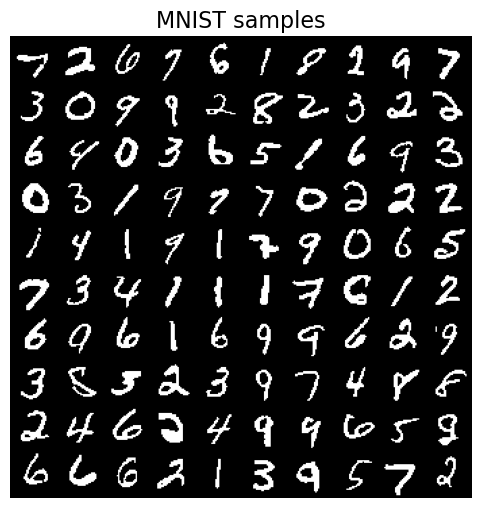

In [3]:
train_data, test_data = load_dataset("mnist", flatten=False, binarize=True)
visualize_images(train_data.astype(float), "MNIST samples")

Please note that our data is **discrete**, and, moreover, it is **binary**.

For this task, the neural networks $s(\cdot)$ and $t(\cdot)$ will be implemented using a ViT-like (Vision Transformer) architecture.

You may either implement the ViT yourself or use the version provided in [this repository](https://github.com/shub-garg/Vision-Transformer-VIT-for-MNIST/tree/main).

If you find it useful, consider giving the repository a star!

  

Implement a class ViTEncoder that takes images as input and produces embeddings for each patch.

These patch embeddings will then be passed to the ViTAffineConditioner, which reconstructs the functions $s(\cdot)$ and $t(\cdot)$ from them.

In [4]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)


class PreNorm(nn.Module):
    def __init__(self, dim: int, fn: nn.Module) -> None:
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x: torch.Tensor, **kwargs) -> torch.Tensor:
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim: int, hidden_dim: int, dropout: float = 0.0) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),  # nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim: int, heads: int = 4, dim_head: int = 64, dropout: float = 0.0) -> None:
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head**-0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(nn.Linear(inner_dim, dim), nn.Dropout(dropout)) if project_out else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _, _, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, "b n (h d) -> b h n d", h=h), qkv)

        dots = einsum("b h i d, b h j d -> b h i j", q, k) * self.scale

        attn = self.attend(dots)

        out = einsum("b h i j, b h j d -> b h i d", attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim: int, depth: int, heads: int, dim_head: int, mlp_dim: int, dropout: float = 0.0) -> None:
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(
                nn.ModuleList(
                    [
                        PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                        PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout)),
                    ]
                )
            )

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class ViTEncoder(nn.Module):
    def __init__(
        self,
        *,
        image_shape: tuple[int, int] | int,
        patch_shape: tuple[int, int] | int,
        dim: int,
        depth: int,
        heads: int,
        mlp_dim: int,
        n_channels: int = 3,
        dim_head: int = 64,
        dropout: float = 0.0,
        emb_dropout: float = 0.0,
    ) -> None:
        super().__init__()
        # ====
        # your code
        self.patch_height = patch_shape[0]
        self.patch_width = patch_shape[1]
        patch_dim  = n_channels * self.patch_height * self.patch_width

        image_height = image_shape[0]
        image_width = image_shape[1]

        num_patches = (image_height // self.patch_height) * (image_width // self.patch_width)

        # 1) create embedder for patches
        self.to_patch_emb = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = self.patch_height, p2 = self.patch_width),
            nn.Linear(patch_dim, dim),
        )
        # 2) create positional embedding
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_emb = nn.Parameter(torch.rand(1, num_patches + 1, dim))
        self.dim = dim
        # 3) create transformer
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout=dropout)
        # ====

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # 1) patch image and compute embeddings
        x = self.to_patch_emb(img)
        b, n, _ = x.shape
        # 2) compute positional embeddings
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_emb[:, :(n + 1)]
        # 3) apply transformer and get representations for each patch
        x = self.transformer(x)
        # ====
        return x

Write `ViTAffineConditioner` that returns $s(\cdot)$ and $t(\cdot)$ after `ViTEncoder`.

In [ ]:
class ViTAffineConditioner(nn.Module):
    def __init__(self, vit: ViTEncoder):
        super().__init__()
        # ====
        # your code
        # create heads for s and t
        self.vit = vit
        dim = vit.dim
        self.head_s = nn.Linear(dim, 1)
        self.head_t = nn.Linear(dim, 1)
        # ====

    def forward(self, img: torch.Tensor):
        # ====
        # your code
        # 1) Encode image into patch tokens via ViTEncoder
        patch_tokens = self.vit(img)  # (B, N+1, D) where N is number of patches
        
        # Remove CLS token and get patch representations
        patch_repr = patch_tokens[:, 1:, :]  # (B, N, D)
        
        # Apply heads for s, t
        s = self.head_s(patch_repr)  # (B, N, 1)
        t = self.head_t(patch_repr)  # (B, N, 1)
        
        # Reshape back to image shape
        B = img.shape[0]
        C = img.shape[1]
        H, W = img.shape[2], img.shape[3]
        patch_H =  self.vit.patch_height
        patch_W = self.vit.patch_width
        
        # Calculate number of patches
        num_patches_H = H // patch_H
        num_patches_W = W // patch_W
        
        s = s.reshape(B, 1, num_patches_H, num_patches_W)
        t = t.reshape(B, 1, num_patches_H, num_patches_W)

        s = s.repeat(1, C, 1, 1)  # Create actual copies for each channel
        t = t.repeat(1, C, 1, 1)
        
        # Upsample to match image resolution
        s = F.interpolate(s, size=(H, W), mode='nearest')
        t = F.interpolate(t, size=(H, W), mode='nearest')

        
        # ====
        return s, t

We have to implement coupling layer for images. To split image in two parts we will you **checkerboard** and **chanelwise** splitting (see image below).

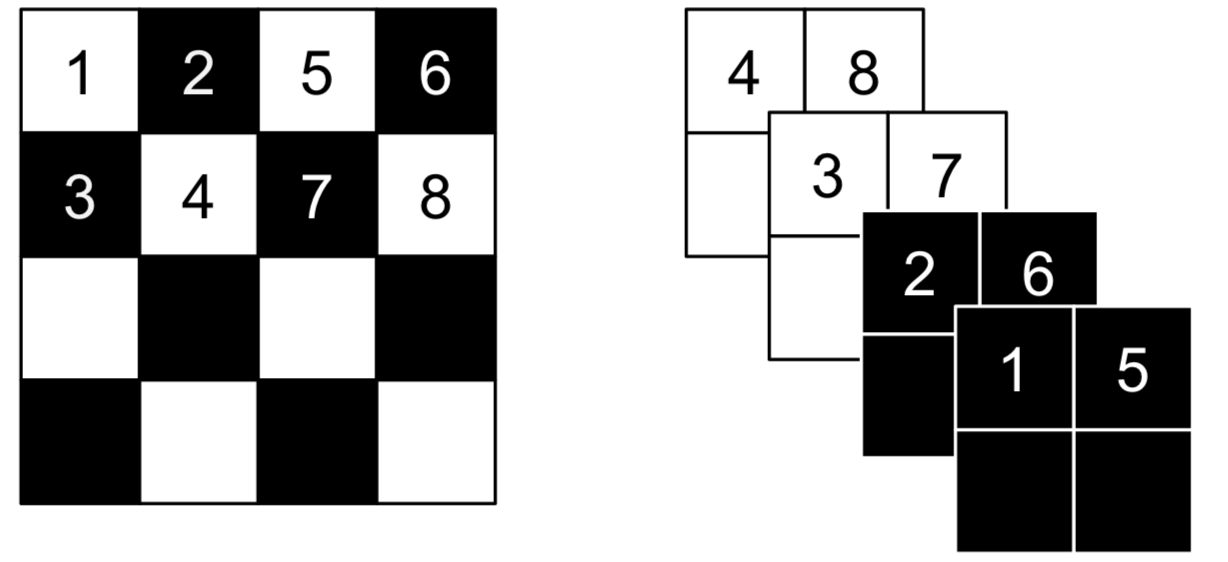

Firstly, let implement checkerboard splitting.

In [6]:
class AffineCheckerboardCouplingLayer(BaseModel):
    def __init__(
        self,
        parity_type: bool,
        image_shape: tuple[int, int],
        patch_shape: tuple[int, int] | int,
        dim: int = 128,
        depth: int = 2,
        heads: int = 4,
        mlp_dim: int = 256,
        n_channels: int = 1,
    ) -> None:
        super().__init__()
        assert isinstance(parity_type, bool)
        self.image_shape = image_shape
        self.parity_type = parity_type
        self.mask = self.build_mask()
        self.scale = nn.Parameter(torch.zeros(1))
        self.scale_shift = nn.Parameter(torch.zeros(1))

        # ====
        # your code
        # define ViTAffineConditioner that will output s() and t()
        vit_encoder = ViTEncoder(
            image_shape=image_shape,
            patch_shape=patch_shape,
            dim=dim,
            depth=depth,
            heads=heads,
            mlp_dim=mlp_dim,
            n_channels=n_channels,
        )
        self.conditioner = ViTAffineConditioner(vit_encoder)
        # ====

    def build_mask(self) -> torch.Tensor:
        # ====
        # your code
        # return checkerboard mask
        # if parity_type == True, the top left corner will be 1.0
        # if parity_type == False, the top left corner will be 0.0
        H, W = self.image_shape
        mask = np.zeros((1, 1, H, W))
        
        if self.parity_type:
            # Top left corner is 1.0
            for i in range(H):
                for j in range(W):
                    if (i + j) % 2 == 0:
                        mask[0,0, i, j] = 1.0
        else:
            # Top left corner is 0.0
            for i in range(H):
                for j in range(W):
                    if (i + j) % 2 == 1:
                        mask[0,0, i, j] = 1.0
        
        # ====
        assert mask.shape[1:] == (1, *self.image_shape)
        return torch.tensor(mask.astype("float32"))

    def forward(self, x: torch.Tensor, invert: bool = False) -> tuple:
        batch_size = x.shape[0]
        mask = self.mask.repeat(batch_size, 1, 1, 1).to(self.device)

        # ====
        # your code
        # 1) mask tensor x
        # 2) apply ViTAffineConditioner to masked x to get s and t
        masked_x = x * mask
        s, t = self.conditioner(masked_x)
        # ====
        # this formula is described in Section 4.1 in original paper
        # just left it unchanged
        s = self.scale * torch.tanh(s) + self.scale_shift
        t = t * (1.0 - mask)
        s = s * (1.0 - mask)

        # ====
        # your code
        # apply forward (invert=False) or inverse (invert=True) transform
        if not invert:
            # Forward transform: y = x * exp(s) + t
            y = x * torch.exp(s) + t
        else:
            # Inverse transform: x = (y - t) * exp(-s)
            y = (x - t) * torch.exp(-s)
        # ====
        return y, s

In [7]:
def test_affine_checkerboard_coupling_layer(device: str = DEVICE):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(0)

    x = torch.zeros((1, 1, 2, 2), dtype=torch.float32, device=device)

    for parity, mask_pattern in zip(
        [True, False],
        [[[1, 0], [0, 1]], [[0, 1], [1, 0]]],
    ):
        layer = AffineCheckerboardCouplingLayer(
            parity_type=parity,
            image_shape=(2, 2),
            patch_shape=(1, 1),
            dim=16,
            mlp_dim=32,
            n_channels=1,
        ).to(device)

        y, s = layer(x)

        # Shape checks
        assert y.shape == s.shape == (1, 1, 2, 2)

        # Mask consistency
        mask = torch.tensor(mask_pattern, dtype=torch.float32, device=device)
        assert torch.allclose(
            y[0, 0] * mask, torch.zeros_like(mask), atol=1e-6
        ), f"Masked positions should remain unchanged for parity={parity}"
        assert torch.allclose(s, torch.zeros_like(s), atol=1e-6), "Scale output should be zero-initialized"

    print("test_affine_checkerboard_coupling_layer passed!")


# Run the test
test_affine_checkerboard_coupling_layer()

test_affine_checkerboard_coupling_layer passed!


Secodly, let implement channelwise splitting.

In [ ]:
class AffineChannelCouplingLayer(nn.Module):
    def __init__(
        self,
        parity_type: bool,
        image_shape: tuple[int, int] | int,
        patch_shape: tuple[int, int] | int,
        dim: int = 128,
        depth: int = 2,
        heads: int = 4,
        mlp_dim: int = 256,
        n_channels: int = 2,
    ) -> None:
        assert isinstance(parity_type, bool)
        super().__init__()
        self.parity_type = parity_type
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        # ====
        # your code
        # define ViTAffineConditioner that will output s() and t()
        # We need to use half the channels for conditioning
        vit_encoder = ViTEncoder(
            image_shape=image_shape,
            patch_shape=patch_shape,
            dim=dim,
            depth=depth,
            heads=heads,
            mlp_dim=mlp_dim,
            n_channels=n_channels // 2,
        )
        self.conditioner = ViTAffineConditioner(vit_encoder)
        # ====

    def forward(self, x: torch.Tensor, invert: bool = False) -> torch.Tensor:
        n_channels = x.shape[1]

        # ====
        # your code
        # 1) split x to two equal parts by channel dimension (dim=1)
        # 2) apply ViTAffineConditioner to masked x
        half_channels = n_channels // 2
        
        if self.parity_type is False: # parity=True => last 2 channels active
            # First half unchanged, second half transformed
            z = x[:, :half_channels]  # Keep first half unchanged
            z_split = x[:, half_channels:]  # Transform second half
        else:
            # First half transformed, second half unchanged
            z_split = x[:, :half_channels]  # Transform first half
            z = x[:, half_channels:]  # Keep second half unchanged
        
        # Apply conditioner to the part that will be used for conditioning
        s, t = self.conditioner(z_split)
        # ====

        # this formula is described in Section 4.1 in original paper
        # just left it unchanged
        s = self.scale * torch.tanh(s) + self.scale_shift

        # ====
        # your code
        # apply forward (invert=False) or inverse (invert=True) transform
        if not invert:
            # Forward transform: y = x * exp(s) + t
            z_split = z_split * torch.exp(s) + t
        else:
            # Inverse transform: x = (y - t) * exp(-s)
            z_split = (z_split - t) * torch.exp(-s)
        # ====

        # look carefully at this piece of code
        if self.parity_type is False:
            z = torch.cat([z, z_split], dim=1)
            s = torch.cat([torch.zeros_like(s), s], dim=1)
        else:
            z = torch.cat([z_split, z], dim=1)
            s = torch.cat([s, torch.zeros_like(s)], dim=1)
        return z, s

In [64]:
def test_affine_channel_coupling_layer(device: str = DEVICE):
    torch.manual_seed(0)

    # Small dummy input
    x = torch.zeros((1, 4, 2, 2), dtype=torch.float32, device=device)

    # Two parity configurations
    for parity, mask_pattern in zip(
        [True, False],
        [
            # parity=True => last 2 channels active
            np.array(
                [[[0, 0], [0, 0]], [[0, 0], [0, 0]], [[1, 1], [1, 1]], [[1, 1], [1, 1]]],
                dtype=np.float32,
            ),
            # parity=False => first 2 channels active
            np.array(
                [[[1, 1], [1, 1]], [[1, 1], [1, 1]], [[0, 0], [0, 0]], [[0, 0], [0, 0]]],
                dtype=np.float32,
            ),
        ],
    ):
        layer = AffineChannelCouplingLayer(
            parity_type=parity,
            image_shape=(2, 2),
            patch_shape=(1, 1),
            dim=16,
            mlp_dim=32,
            n_channels=4,
        ).to(device)

        y, s = layer(x)

        # Shape checks
        assert y.shape == s.shape == (1, 4, 2, 2), f"Unexpected output shape for parity={parity}"

        # Mask checks
        mask = torch.tensor(mask_pattern, dtype=torch.float32, device=device)
        masked_y = y[0] * mask
        assert torch.allclose(
            masked_y, torch.zeros_like(masked_y), atol=1e-6
        ), f"Masked positions should remain unchanged for parity={parity}"
        assert torch.allclose(
            s, torch.zeros_like(s), atol=1e-6
        ), f"Scale output should be zero-initialized for parity={parity}"

    print("test_affine_channel_coupling_layer passed!")


test_affine_channel_coupling_layer()

test_affine_channel_coupling_layer passed!


We will use the following normalization layer for more stable training. Look carefully at the class below (do not chage it).

In [ ]:
class ActNormLayer(nn.Module):
    def __init__(self, n_channels: int) -> None:
        super().__init__()
        self.log_scale = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.shift = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.n_channels = n_channels
        self.initialized = False

    def forward(self, x: torch.Tensor, invert: bool = False) -> torch.Tensor:
        if invert:
            return (x - self.shift) * torch.exp(-self.log_scale), self.log_scale
        else:
            if not self.initialized:
                self.shift.data = -torch.mean(x, dim=[0, 2, 3], keepdim=True)
                self.log_scale.data = -torch.log(
                    torch.std(x.permute(1, 0, 2, 3).reshape(self.n_channels, -1), dim=1).reshape(
                        1, self.n_channels, 1, 1
                    )
                )
                self.initialized = True
            return x * torch.exp(self.log_scale) + self.shift, self.log_scale

Our data is discrete. The normalizing flow model works with continuous data (it is a requirement of CoV theorem).

Therefore, we have to convert our discrete data to continuous one. This process is called **dequantization**. We will discuss it later in lectures.

To dequantize the discrete variable $x \in \{0, 1, \dots, K - 1\}$ we add uniform noise to it:
$$
    y = x + u, \quad u \sim \text{Uniform}[0, 1].
$$

Then random variable $y \in [0, K]$ will be continuous and in fact similar to $x$.

Let implement simple function for such dequantization.

In [11]:
def dequantize(x: torch.Tensor, nbins: int = 256) -> torch.Tensor:
    return (x * (nbins - 1) + torch.distributions.Uniform(0.0, 1.0).sample(x.shape).to(x.device)) / nbins


def test_dequantize():
    x = torch.tensor((0, 1, 2, 3)) / 256.0
    y = dequantize(x).cpu().detach().numpy()
    x = x.cpu().detach().numpy()
    assert y.min() >= 0.0
    assert y.max() <= 4 / 256.0
    assert (y[3] > y[2]) and (y[2] > y[1]) and (y[1] > y[0])
    assert (y[3] > x[3]) and (y[2] > x[2]) and (y[1] > x[1]) and (y[0] > x[0])


test_dequantize()

The second issue that we will address here is the boundedness of the image domain. It is more natural for the model to fit the data from the range $(-\infty, +\infty)$.

The most natural way to convert $(-\infty, +\infty)$ range to the $[0, 1]$ is to apply sigmoid function. But here we need the inverse transform from [0, 1] range (it is normalized dequantized images) to $(-\infty, +\infty)$. So we need to apply inverse sigmoid function. This function is called logit:
$$
    \text{logit}(x) = \log \left( \frac{x}{1 - x} \right) = \log (x) - \log (1 - x).
$$

The last note here is the stability of this transform. To make it stable the common practice is to convert [0, 1] range to the $[\alpha, 1 - \alpha]$ firstly (where $\alpha$ is a small constant):
$$
    \text{logit}(x) = \log (y) - \log (1 - y), \quad \text{where } y = \alpha + (1 - 2 * \alpha) * x.
$$

Also we need the logarithm of the Jacobian' determinant for this transform. We implement this for you, but we really encourage you to check that the formula in the code is correct for better understanding.

In [13]:
class LogitTransform(nn.Module):
    def __init__(self, alpha: float = 0.05, dequantize: bool = True, nbins: int = 256) -> None:
        super().__init__()
        self.alpha = alpha
        self.dequantize = dequantize
        self.nbins = nbins

    def forward(self, x: torch.Tensor, invert: bool = False) -> tuple:
        if invert:
            log_det = -x - 2 * F.softplus(-x) - torch.log(torch.tensor(1 - 2 * self.alpha))
            x = (torch.sigmoid(x) - self.alpha) / (1 - 2 * self.alpha)
        else:
            # dequantization
            if self.dequantize:
                x = dequantize(x, nbins=self.nbins)

            # ====
            # your code
            # 1) scale the data to [alpha, 1 - alpha range] (save the result to x_scaled)
            x_scaled = self.alpha + (1 - 2 * self.alpha) * x
            # 2) apply logit operation that described above (save the result to x)
            x = torch.log(x_scaled) - torch.log(1.0 - x_scaled)
            # ====

            # look carefully at this expression, try to understand this formula
            log_det = -torch.log(x_scaled) - torch.log(1.0 - x_scaled) + torch.log(torch.tensor(1 - 2 * self.alpha))
        return x, log_det


def test_logit_transform():
    layer = LogitTransform(dequantize=False)
    x = torch.tensor((0, 1, 2, 3)) / 256.0
    z, log_det = layer(x)
    assert np.allclose(
        z.cpu().detach().numpy(),
        np.array([-2.944439, -2.8727808, -2.8054335, -2.7418802]),
    )
    assert np.allclose(
        log_det.cpu().detach().numpy(),
        np.array([2.9416652, 2.8774219, 2.8175175, 2.7614343]),
    )

    x_restored, _ = layer(z, invert=True)
    assert np.allclose(x.cpu().detach().numpy(), x_restored.cpu().detach().numpy())


test_logit_transform()

Not it is time to define the final model.

The model will consist of several blocks:

1. Logit Transform (to convert the data to $(-\infty, \infty)$ range).
2. Stack of checkerboard coupling layers.
3. Squeeze operation (convert tensor $[B, C, H, W]$ to $[B, 4 * C, H / 2, W / 2]$).
4. Stack of channelwise coupling layers
5. Unsqueeze operation (convert tensor $[B, C, H, W]$ to $[B, C / 4, 2 * H, 2 * W]$).
2. Stack of checkerboard coupling layers.

In [69]:
class RealNVP(BaseModel):
    def __init__(
        self,
        image_shape: tuple[int, int],
        patch_shape: tuple[int, int],
        dim: int = 128,
        depth: int = 2,
        heads: int = 4,
        mlp_dim: int = 256,
        n_channels: int = 1,
        nbins: int = 256,
    ) -> None:
        super().__init__()
        self.image_shape = image_shape
        self.n_channels = n_channels
        self.nbins = nbins

        self.prior = torch.distributions.Normal(loc=torch.tensor(0.0), scale=torch.tensor(1.0))
        self.logit_transform = LogitTransform(nbins=nbins, dequantize=True)

        # ====
        # your code
        # define stack of checkerboard coupling layers with alternating parity_type
        # add ActNormLayer after each coupling layer
        self.transforms1 = nn.ModuleList()
        for i in range(2):  # 2 checkerboard layers
            self.transforms1.append(AffineCheckerboardCouplingLayer(
                parity_type=(i % 2 == 0),
                image_shape=image_shape,
                patch_shape=patch_shape,
                dim=dim,
                depth=depth,
                heads=heads,
                mlp_dim=mlp_dim,
                n_channels=n_channels,
            ))
            self.transforms1.append(ActNormLayer(n_channels))

        # ====

        # ====
        # your code
        # define stack of channel coupling layers with alternating parity_type
        # add ActNormLayer after each coupling layer
        # Hint: do not forget about changed image shape
        squeezed_channels = n_channels * 4
        
        self.transforms2 = nn.ModuleList()
        for i in range(2):  # 2 channel layers
            self.transforms2.append(AffineChannelCouplingLayer(
                parity_type=(i % 2 == 0),
                image_shape=image_shape,
                patch_shape=patch_shape,
                dim=dim,
                depth=depth,
                heads=heads,
                mlp_dim=mlp_dim,
                n_channels=squeezed_channels,
            ))
            self.transforms2.append(ActNormLayer(squeezed_channels))

        # ====

        # ====
        # your code
        # define stack of checkerboard coupling layers with alternating parity_type
        # add ActNormLayer after each coupling layer
        self.transforms3 = nn.ModuleList()
        for i in range(2):  # 2 checkerboard layers
            self.transforms3.append(AffineCheckerboardCouplingLayer(
                parity_type=(i % 2 == 0),
                image_shape=image_shape,
                patch_shape=patch_shape,
                dim=dim,
                depth=depth,
                heads=heads,
                mlp_dim=mlp_dim,
                n_channels=n_channels,
            ))
            self.transforms3.append(ActNormLayer(n_channels))

        # ====

    def squeeze(self, x: torch.Tensor) -> torch.Tensor:
        # Look carefully at this piece of code (do not change)
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
        return x

    def undo_squeeze(self, x: torch.Tensor) -> torch.Tensor:
        # Look carefully at this piece of code (do not change)
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
        return x

    def forward(self, x: torch.Tensor, invert: bool = False) -> tuple:
        z = x
        log_det = torch.zeros_like(x, dtype=float)
        if invert:
            for op in reversed(self.transforms3):
                z, delta_log_det = op.forward(z, invert=True)
                log_det += delta_log_det
            z, log_det = self.squeeze(z), self.squeeze(log_det)
            for op in reversed(self.transforms2):
                z, delta_log_det = op.forward(z, invert=True)
                log_det += delta_log_det
            z, log_det = self.undo_squeeze(z), self.undo_squeeze(log_det)
            for op in reversed(self.transforms1):
                z, delta_log_det = op.forward(z, invert=True)
                log_det += delta_log_det
            z, delta_log_det = self.logit_transform(z, invert=True)
            log_det += delta_log_det
        else:
            z, delta_log_det = self.logit_transform(z)
            log_det += delta_log_det
            for op in self.transforms1:
                z, delta_log_det = op.forward(z)
                log_det += delta_log_det
            z, log_det = self.squeeze(z), self.squeeze(log_det)
            for op in self.transforms2:
                z, delta_log_det = op.forward(z)
                log_det += delta_log_det
            z, log_det = self.undo_squeeze(z), self.undo_squeeze(log_det)
            for op in self.transforms3:
                z, delta_log_det = op.forward(z)
                log_det += delta_log_det
        return z, log_det

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        self.prior.loc = self.prior.loc.to(self.device)
        self.prior.scale = self.prior.scale.to(self.device)
        # ====
        # your code
        # 1) make forward pass with right inverse flag
        # 2) sum log_det with log of base distribution (log p(z))
        # 3) we will get tensor of shape [batch_size, 3, H, W] - sum it over the the last 3 dimensions
        z, log_det = self.forward(x, invert=False)
        
        # Calculate log probability of z under the base distribution
        log_prob_z = self.prior.log_prob(z)
        
        # Sum over spatial dimensions and add log determinant
        log_prob = log_prob_z.sum(dim=[1, 2, 3]) + log_det.sum(dim=[1, 2, 3])
        
        return log_prob
        # ====

    def loss(self, x: torch.Tensor) -> dict:
        return {"nll_loss": -self.log_prob(x).mean()}

    def sample(self, num_samples: int) -> np.ndarray:
        self.prior.loc = self.prior.loc.to(self.device)
        self.prior.scale = self.prior.scale.to(self.device)
        # Look carefully at this piece of code (do not change)
        z = self.prior.sample([num_samples, self.n_channels, *self.image_shape])
        samples = self.forward(z, invert=True)[0]
        samples = samples.cpu().detach().numpy()
        samples = np.floor(np.clip(samples * self.nbins, 0.0, self.nbins - 1)) / (self.nbins - 1)
        return samples

In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 50
LR = 1e-3
DIM = 256
DEPTH = 4
HEADS = 16
MLP_DIM = 1024
# ====

# model
model = RealNVP(
    image_shape=(32, 32),
    patch_shape=(8, 8),
    dim=DIM,
    depth=DEPTH,
    heads=HEADS,
    mlp_dim=MLP_DIM,
    n_channels=1,
    nbins=2,
)

Let train this model :)

The model can be challenging to train, so don't be discouraged by poor initial samples. For better results, train the model for more than an hour.

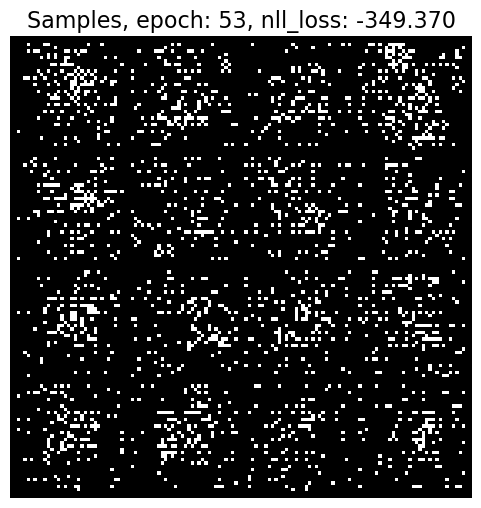

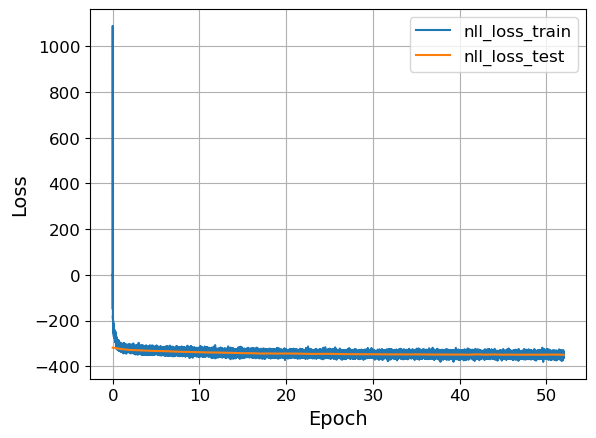

Training epoch 54:   0%|          | 0/1200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [83]:
loader_args = dict(batch_size=BATCH_SIZE, shuffle=True)
train_loader = data.DataLoader(train_data, **loader_args)
test_loader = data.DataLoader(test_data, **loader_args)

# ====
# your code
# choose any optimizer/scheduler as you want
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
# ====

# train
EPOCHS = 100

train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    device=DEVICE,
    n_samples=16,
    visualize_samples=True,
    loss_key="nll_loss",
)